In [1]:
import numpy as np
import pandas as pd
from pprint import pprint
from movie import *
import pickle
from multiprocessing import Pool
from datetime import datetime
from pprint import pprint
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold
import sklearn.datasets as datasets
from sklearn.feature_selection import SelectPercentile,f_classif, f_regression,SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

In [12]:
with open('name_url.pkl','rb') as f:
    name_info=pickle.load(f)

print(name_info['Fahrenheit 9/11(2004)'])

{'Release Date': datetime.datetime(2004, 6, 23, 0, 0), 'url': 'https://www.the-numbers.com/movie/Fahrenheit-9-11', 'Production Budget': 6000000, 'Domestic Gross': 119114517, 'Worldwide Gross': 221148959}


## Frequency of movies

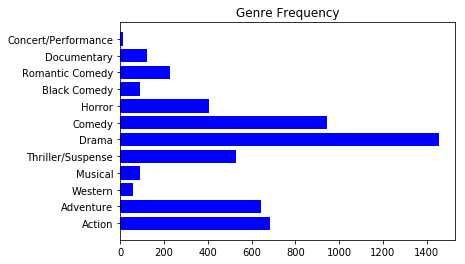

In [45]:
with open('movie_categories.pkl','rb') as f:
    cate_info=pickle.load(f)

dic=cate_info['Genre']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Genre Frequency')
plt.show()

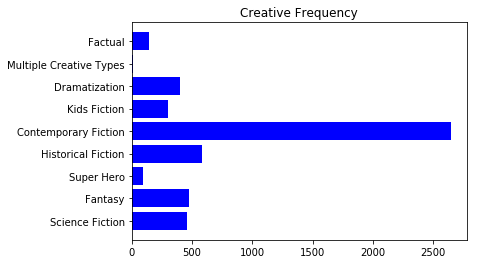

In [46]:
dic=cate_info['Creative Type']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Creative Frequency')
plt.show()

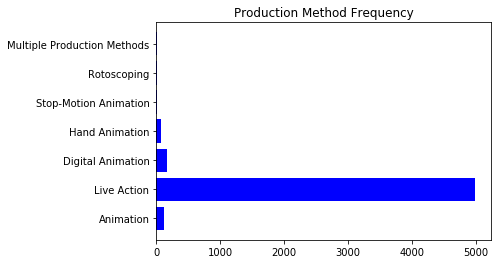

In [47]:
dic=cate_info['Production Method']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Production Method Frequency')
plt.show()

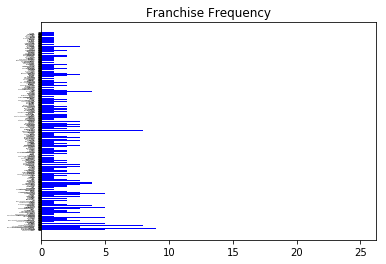

In [56]:
dic=cate_info['Franchise']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Franchise Frequency')
plt.tick_params(axis='y', which='major', labelsize=1)
plt.show()

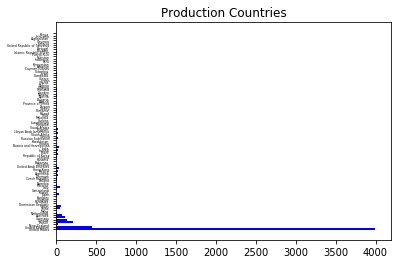

In [60]:
dic=cate_info['Production Countries']
name_list =  list(dic.keys())
num_list = [len(a) for a in dic.values()]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.tick_params(axis='y', which='major', labelsize=3)
plt.title('Production Countries')
plt.show()

## Data preprocessing


In [24]:
def get_roles():
    with open('movie_info.pkl', 'rb') as f:
        movie_info=pickle.load(f)
    
    role_set=set()
    for name,info in movie_info.items():
        if 'production' in info['cast'].keys():
            for person in info['cast']['production']:
                role_set.add(person['role'])
    
    return list(role_set)

In [25]:
print(len(get_roles()))

1965


In [27]:
with open('movie_info.pkl','rb') as f:
    movie_info=pickle.load(f)

with open('name_url.pkl','rb') as f:
    movie_budget=pickle.load(f)
    
def get_person_info_helper(name, movie_info=movie_info, movie_budget=movie_budget):
    
    #print(name)
    person_name_info=dict()
    #cast_url=value+"#tab=cast-and-crew"
    cast_dic=movie_info[name]['cast']
    cast_list=['leading_members', 'supporting_cast', 'cameos', 'uncategorized', 'production']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        for cate in cast_list:
            if cate in cast_dic.keys():
                for person in cast_dic[cate]:
                    person_name=person['name']
                    if person_name in person_name_info.keys():
                        person_name_info[person_name]=set(list(person_name_info[person_name])+[name])
                    else:
                        person_name_info[person_name]=set([name])
                    
    return person_name_info

In [28]:
get_person_info_helper('Black Panther(2018)')

{'Andy Gill': {'Black Panther(2018)'},
 'Andy Serkis': {'Black Panther(2018)'},
 'Angela Bassett': {'Black Panther(2018)'},
 'Atandwa Kani': {'Black Panther(2018)'},
 'Chadwick Boseman': {'Black Panther(2018)'},
 'Claudia Castello': {'Black Panther(2018)'},
 'Connie Chuene': {'Black Panther(2018)'},
 'Danai Gurira': {'Black Panther(2018)'},
 'Daniel Kaluuya': {'Black Panther(2018)'},
 'Dave Jordan': {'Black Panther(2018)'},
 'David J. Grant': {'Black Panther(2018)'},
 'Florence Kasumba': {'Black Panther(2018)'},
 'Forest Whitaker': {'Black Panther(2018)'},
 'Geoffrey Baumann': {'Black Panther(2018)'},
 'Hannah Beachler': {'Black Panther(2018)'},
 'Isaach de Bankole': {'Black Panther(2018)'},
 'Jack Kirby': {'Black Panther(2018)'},
 'Jeffrey Chernov': {'Black Panther(2018)'},
 'Joe Robert Cole': {'Black Panther(2018)'},
 'John Kani': {'Black Panther(2018)'},
 'Kevin Feige': {'Black Panther(2018)'},
 'Letitia Wright': {'Black Panther(2018)'},
 'Louis D’Esposito': {'Black Panther(2018)'},

In [29]:
def get_all_person_urls():
    with open('movie_info.pkl', 'rb') as f:
        movie_info=pickle.load(f)
    
    with open('name_url.pkl','rb') as f:
        movie_budget=pickle.load(f)
    
    total_dic=dict()
    keys=list(movie_info.keys())
    pool = Pool(processes=10)
    pool_outputs = pool.map(get_person_info_helper,keys)
    pool.close()
    pool.join()
    
    for item in pool_outputs:
        for key, value in item.items():
            total_dic[key.strip()]=set(list(total_dic.get(key.strip(),[]))+list(value))
    
    final_dic=dict()
    for key, value in total_dic.items():
        total_sum=0
        total_count=0
        for name in value:
            total_sum+=movie_budget[name]['Worldwide Gross']
            total_count+=1
        
        final_dic[key]=math.log(total_sum/(total_count+0.1)+1)
    
    with open('person_info.pkl','wb') as f:
        pickle.dump(final_dic, f)
        
    return

In [30]:
get_all_person_urls()

[('Jim McGrath', 21.350012024183115), ('Jessica Sherman', 21.350012024183115), ('Rachel Dill', 21.350012024183115), ('Janet Lewin', 21.350012024183115), ("Luke O'Byrne", 21.350012024183115), ('James Clyne', 21.350012024183115), ('Kevin Jenkins', 21.350012024183115), ('Oliver Roberts', 21.350012024183115), ('Aaron E. Schneider', 21.420137163394873), ('Sean Anthony Moran', 21.65181529829283), ('Jason Whyte', 21.65181529829283), ('James Pitt', 21.65181529829283), ('Peter Dillon', 21.65181529829283), ('Kelson Henderson', 21.65181529829283), ('David Van Horn', 21.65181529829283), ('Sonia Yee', 21.65181529829283), ('Jahnel Curfman', 21.65181529829283), ('Kyla Warren', 21.65181529829283), ('Lucy Briant', 21.65181529829283), ('Nathan Meister', 21.65181529829283), ('Gerry Blair', 21.65181529829283), ('Matt Chamberlain', 21.65181529829283), ('Paul Yates', 21.65181529829283), ('Wray Wilson', 21.65181529829283), ('Yuri Bartoli', 21.65181529829283), ('Nick Bassett', 21.65181529829283), ('Rob Bavin'

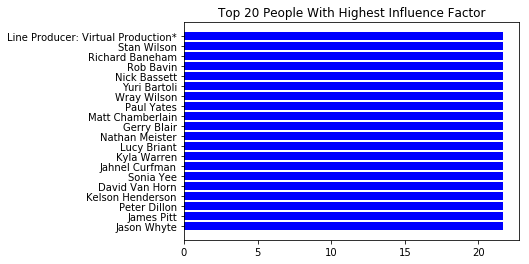

In [31]:
import operator
with open('person_info.pkl', 'rb') as f:
    person_info=pickle.load(f)
    
sorted_person=sorted(person_info.items(), key=lambda d: d[1])
print(sorted_person[-30:-1])
target=sorted_person[-20:]
name_list = [a[0] for a in target]
num_list = [a[1] for a in target]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Top 20 People With Highest Influence Factor')
plt.show()

In [32]:
import math
with open('movie_info.pkl','rb') as f:
    movie_info=pickle.load(f)
    
with open('name_url.pkl','rb') as f:
    movie_budget=pickle.load(f)
    
def get_company_info_helper(name, movie_info=movie_info, movie_budget=movie_budget):
    
    company_name_info=dict()
    cast_dic=movie_info[name]['summary']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        if 'Production Companies' in cast_dic.keys():
            for company in cast_dic['Production Companies']:
                #print(name, company.strip())
                bo=movie_budget[name]['Worldwide Gross']
                company_name_info[company.strip()]=company_name_info.get(company.strip(),[])+[bo]
    
    return company_name_info

In [33]:
def get_all_company_info():
    with open('movie_info.pkl', 'rb') as f:
        movie_info=pickle.load(f)
    
    total_dic=dict()
    keys=list(movie_info.keys())
    pool = Pool(processes=10)
    pool_outputs = pool.map(get_company_info_helper,keys)
    pool.close()
    pool.join()
    
    for item in pool_outputs:
        for key, value in item.items():
            total_dic[key.strip()]=total_dic.get(key.strip(),[])+value
    
    #pprint(total_dic)
    company_info=dict()
    for key,value in total_dic.items():
        company_info[key]=math.log(np.sum(np.array(value))/(len(value)+0.1)+1)
    
    with open('company_info.pkl','wb') as f:
        pickle.dump(company_info, f)
        
    return    

In [34]:
get_all_company_info()

[('Fairview Entertainment', 20.16510458271864), ('Kevin Feige', 20.188834252435928), ('Seven Bucks Productions', 20.196674530670407), ('DC Films', 20.206290199799334), ('John Calley', 20.211405000627998), ('Marvel Studios', 20.222776876389098), ('Steve Tisch Productions', 20.2420735023506), ('Esperanto Filmoj', 20.265466411578196), ('Ingenious Film Partners', 20.267055609994152), ('KatzSmith Productions', 20.267644437243806), ('Disney-Pixar', 20.281660856290824), ('Laura Ziskin Productions', 20.301337701538994), ('Tencent Pictures', 20.30207090709969), ('One Race Films', 20.320634559484038), ('Chris Meledandri', 20.326245639902215), ('Lucasfilm', 20.32877095859611), ('Simon Kinberg', 20.337419884892842), ('Wingnut Films', 20.346044102071257), ('Heyday Films', 20.35786380039569), ('Illumination Entertainment', 20.386172563069625), ('China Film Company', 20.409429556800788), ('Wanda Pictures', 20.42585515967782), ('Syncopy', 20.460710614331887), ('Fuji Television Network', 20.50784828028

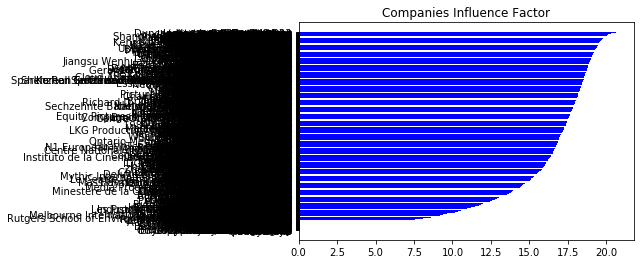

In [35]:
import operator
with open('company_info.pkl', 'rb') as f:
    company_info=pickle.load(f)

sorted_company=sorted(company_info.items(), key=lambda d: d[1])
print(sorted_company[-30:])

target=sorted_company
name_list = [a[0] for a in target]
num_list = [a[1] for a in target]
plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
plt.title('Companies Influence Factor')
plt.show()

In [36]:
def get_all_cate_info():
    with open('movie_categories.pkl', 'rb') as f:
        categories_info=pickle.load(f)
    
    with open('name_url.pkl','rb') as f:
        movie_budget=pickle.load(f)
    
    key_list=['Keywords', 'Production Method', 'Franchise', 'Creative Type', 'Genre', 'Production Companies']
    for key in key_list:
        dic=categories_info[key]
        total_dic=dict()
        for name in dic.keys():
            total_sum=0
            total_count=0
            for movie in dic[name]:
                total_sum+=movie_budget[movie]['Worldwide Gross']
                total_count+=1
            total_dic[name]=math.log(total_sum/(total_count+0.1)+1)
        file_name='_'.join(key.lower().split())
        with open(file_name+'.pkl','wb') as f:
            pickle.dump(total_dic, f)
        
    return    

In [37]:
get_all_cate_info()

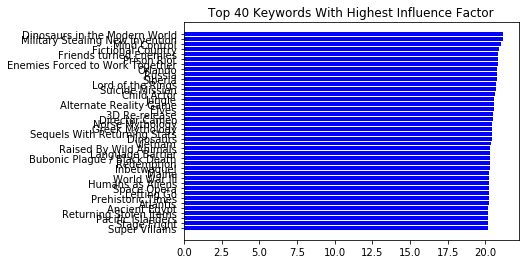

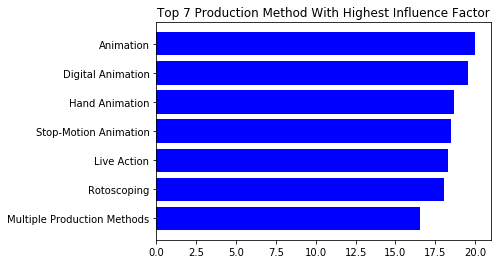

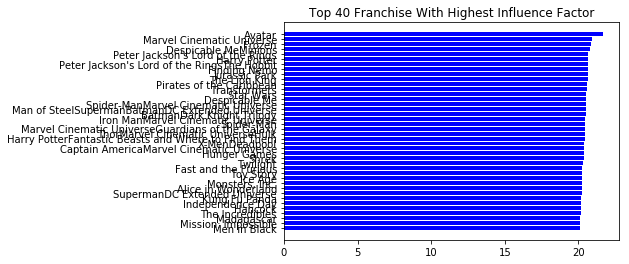

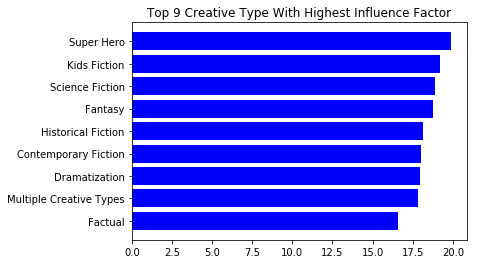

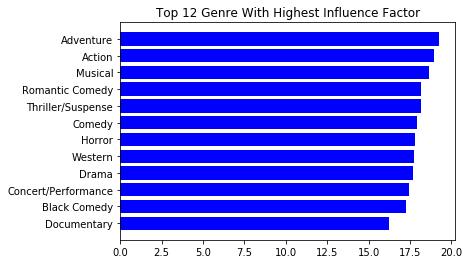

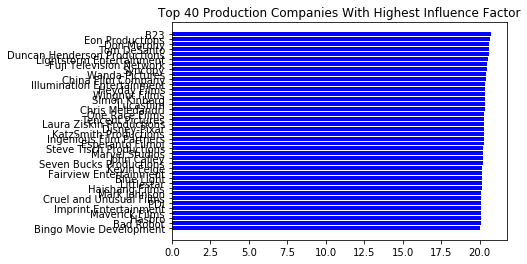

In [38]:
import operator

key_list=['Keywords', 'Production Method', 'Franchise', 'Creative Type', 'Genre', 'Production Companies']
for key in key_list:
    file_name='_'.join(key.lower().split())
    #print(file_name)
    with open(file_name+'.pkl','rb') as f:
        movie_info=pickle.load(f)
    sorted_movie=sorted(movie_info.items(), key=lambda d: d[1])
    #print(sorted_movie[-30:])
    target=sorted_movie[-40:]
    name_list = [a[0] for a in target]
    num_list = [a[1] for a in target]
    plt.barh(range(len(num_list)), num_list,fc='b',tick_label=name_list)
    plt.title('Top '+ str(len(name_list)) +' '+key+' With Highest Influence Factor')
    plt.show()

## Feature Selection


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


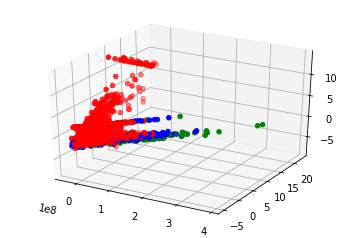

In [43]:
visual_list=dict()

with open('movie_info.pkl', 'rb') as f:
    movie_info=pickle.load(f)
    
with open('person_info.pkl', 'rb') as f:
    person_info=pickle.load(f)
    
with open('name_url.pkl', 'rb') as f:
    movie_budget=pickle.load(f)

visual_y=list()
movie_name=list()
visual_list['budget']=list()
visual_list['cast']=list()
total_info=dict()
key_list=['Keywords', 'Production Method', 'Franchise', 'Creative Type', 'Genre', 'Production Companies']
for key in key_list:
    file_name='_'.join(key.lower().split())
    visual_list[file_name]=list()
    with open(file_name+'.pkl','rb') as f:
        total_info[file_name]=pickle.load(f)

for name in movie_info.keys():
    cast_dic=movie_info[name]['cast']
    cast_list=['leading_members', 'production']
    if name in movie_budget.keys() and movie_budget[name]['Release Date']<datetime.now():
        movie_name.append(name)
        test_value=math.log(movie_budget[name]['Worldwide Gross']+1)
        if test_value<15:
            visual_y.append('r')
        elif test_value<18:
            visual_y.append('b')
        else:
            visual_y.append('g')
            
        tmplist=list()
        for cate in cast_list:
            if cate in cast_dic.keys():
                for person in cast_dic[cate]:
                    person_name=person['name'].strip()
                    tmplist.append(person_info[person_name])
        
        visual_list['cast'].append(np.mean(np.array(tmplist)))
        visual_list['budget'].append(movie_budget[name]['Production Budget'])
        
        key_list=['Franchise', 'Creative Type', 'Genre']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            if key in movie_info[name]['summary'].keys():
                cate=movie_info[name]['summary'][key].strip()
                visual_list[file_name].append(total_info[file_name][cate])
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
        
        key_list=['Keywords', 'Production Method','Production Companies']
        for key in key_list:
            file_name='_'.join(key.lower().split())
            tmplist=list()
            if key in movie_info[name]['summary'].keys():
                for cate in movie_info[name]['summary'][key]:
                    tmplist.append(total_info[file_name][cate.strip()])
                visual_list[file_name].append(np.mean(np.array(tmplist)))
            else:
                visual_list[file_name].append(np.mean(np.array(list(total_info[file_name].values()) )))
                
P=np.array(list(visual_list.values())).T
column_name=np.array(list(visual_list.keys()))
visual_y=np.array(visual_y)
movie_name=np.array(movie_name)
movie_name=movie_name[~np.isnan(P).any(axis=1)]
y_train=visual_y[~np.isnan(P).any(axis=1)]
P=P[~np.isnan(P).any(axis=1)]
pdf=pd.DataFrame(data=P,index=movie_name, columns=column_name)
pdf.to_csv('movie_info.csv')

pca = PCA(n_components=3)
pca.fit(P)
P=pca.transform(P)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(P[:,0],P[:,1],P[:,2], c=y_train)
plt.show()

## Visualize the network


In [5]:
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models.graphs import from_networkx

G=nx.karate_club_graph()

plot = figure(title="Networkx Integration Demonstration", x_range=(-1.1,1.1), y_range=(-1.1,1.1))

graph = from_networkx(G, nx.spring_layout, scale=2, center=(0,0))
plot.renderers.append(graph)

output_notebook()
show(plot)

Loading BokehJS ...